In [2]:
# Here I want to implement the metropolis algorithm, as well as extend the project to 2 dimensions

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm

In [29]:
# Setting Constants

#position boundaries
x_0 = 0
y_0 = 0
x_endpoints = np.linspace(-2, 2, 201)
y_endpoints = np.linspace(-2, 2, 201)

#time boundaries
t_i = 0
t_f = 6

#other constants
mass = 1
steps = 50
numb_paths = 1000

#array of times
times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]
print(x_endpoints)

[-2.   -1.98 -1.96 -1.94 -1.92 -1.9  -1.88 -1.86 -1.84 -1.82 -1.8  -1.78
 -1.76 -1.74 -1.72 -1.7  -1.68 -1.66 -1.64 -1.62 -1.6  -1.58 -1.56 -1.54
 -1.52 -1.5  -1.48 -1.46 -1.44 -1.42 -1.4  -1.38 -1.36 -1.34 -1.32 -1.3
 -1.28 -1.26 -1.24 -1.22 -1.2  -1.18 -1.16 -1.14 -1.12 -1.1  -1.08 -1.06
 -1.04 -1.02 -1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82
 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58
 -0.56 -0.54 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34
 -0.32 -0.3  -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1
 -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14
  0.16  0.18  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38
  0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86
  0.88  0.9   0.92  0.94  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1
  1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.26  1.28

In [30]:
#Basic Path function and action integral
#Creating the position generating function

def Pos_Gen(x0, xN, Steps, noise_scale=0.05):  #Generates smooth paths with noise
    xs = np.linspace(x0, xN, Steps)
    noise = np.random.normal(0, noise_scale, size=Steps)
    noise[0] = 0.0
    noise[-1] = 0.0
    return xs + noise

In [31]:
#Creating function to evaluate the action integral for a path

def action_harmonic(positions, times, mass, potential):
    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times) - 1):
        dt = times[i + 1] - times[i]
        dx = positions[i + 1] - positions[i]
        T = 0.5 * mass * (dx / dt) ** 2

        x_mid = positions[i] + dx/2
        V = potential(x_mid)

        S += dt * (T + V)

    return S

In [32]:
# defining the x and y potentials

def x_potential(x):
    return 0.5*x**2

def y_potential(y):
    # return 0.25*(y**2-1)**2
    if np.abs(y)<1:
        return 0
    if np.abs(y)>1:
        return 1e26

In [ ]:
# Generating Paths and calculating weight of each path for x
paths_x = []
weights_x = []
x_end = []

paths_y =[]
weights_y =[]
y_end = []

for xN in x_endpoints:
    for _ in range(numb_paths):
        p = Pos_Gen(x_0, xN, steps)
        S = action_harmonic(p, times, mass, x_potential)
        w = np.exp(-S)
        paths_x.append(p)
        weights_x.append(w)
        x_end.append(xN)

paths_x = np.array(paths_x)
weights_x = np.array(weights_x)
x_end = np.array(x_end)

iterations = 1_000_000

print(paths_x[0])
print(len(paths_x))
print(paths_x[1001])
# Finding the groundstate wave function of the path
x_bins = np.linspace(-2, 2, 201)

pdf_unnormalised_x, bin_edges_x = np.histogram(x_end, bins=x_bins, weights=weights_x)
x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area = np.sum(pdf_unnormalised_x * dx)
pdf_x = pdf_unnormalised_x / (2 * area)

# --- Analytic PDF for comparison (half side only) ---
phi_sq_analytic = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic /= 2 * np.sum(phi_sq_analytic * dx)  # normalize area to 0.5

In [ ]:
# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic * dx):.5f}")
save_path = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\Summative_Wavefunction"

plt.figure(1)
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=3)
plt.plot(x_centres, phi_sq_analytic, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.savefig(save_path, bbox_inches='tight', format='svg')
plt.show()

In [36]:
#repeating for y
paths_y =[]
weights_y =[]
y_end = []

for yN in y_endpoints:
    for _ in range(numb_paths):
        p = Pos_Gen(y_0, yN, steps)
        S = action_harmonic(p, times, mass, y_potential)
        w = np.exp(-S)
        paths_y.append(p)
        weights_y.append(w)
        y_end.append(yN)

paths_y = np.array(paths_y)
weights_y = np.array(weights_y)
y_end = np.array(y_end)

print(paths_y[0])
print(len(paths_y))
print(paths_y[1001])
# Finding the groundstate wave function of the path
y_bins = np.linspace(-2, 2, 201)

pdf_unnormalised_y, bin_edges_y = np.histogram(y_end, bins=y_bins, weights=weights_y)
y_centres = 0.5 * (bin_edges_y[1:] + bin_edges_y[:-1])
dy = np.diff(y_bins)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area = np.sum(pdf_unnormalised_y * dy)
pdf_y = pdf_unnormalised_y / (2 * area)

[ 0.         -0.05649019 -0.05073266 -0.14202427 -0.22350129 -0.26486518
 -0.20377331 -0.24893034 -0.30366013 -0.37383103 -0.34230671 -0.43343625
 -0.45504543 -0.5004512  -0.49837107 -0.56544217 -0.68932089 -0.7064389
 -0.67668585 -0.79486343 -0.81830552 -0.85491115 -0.86854146 -0.96646215
 -0.98572502 -1.04318839 -1.06662513 -1.25526326 -1.10814123 -1.20748162
 -1.20201641 -1.3439176  -1.33811639 -1.35368865 -1.35290093 -1.43554385
 -1.40521913 -1.58450967 -1.4751694  -1.63834284 -1.57065479 -1.73853448
 -1.68620827 -1.79890662 -1.80598333 -1.76566424 -1.8031866  -1.91332509
 -2.02404389 -2.        ]
201000
[ 0.         -0.04800452 -0.12409237 -0.12924632 -0.18212453 -0.08498069
 -0.25021195 -0.31482691 -0.37207066 -0.40119075 -0.39722789 -0.47128873
 -0.50973249 -0.55166836 -0.57694681 -0.62666088 -0.64863627 -0.68960994
 -0.6714758  -0.68561377 -0.7122971  -0.85710775 -0.85185269 -0.85847964
 -0.9802667  -0.9352156  -0.95654423 -1.09168553 -1.11069018 -1.17430486
 -1.18118527 -1.254

Numerical PDF area: 0.50000
Analytic PDF area: 0.50000


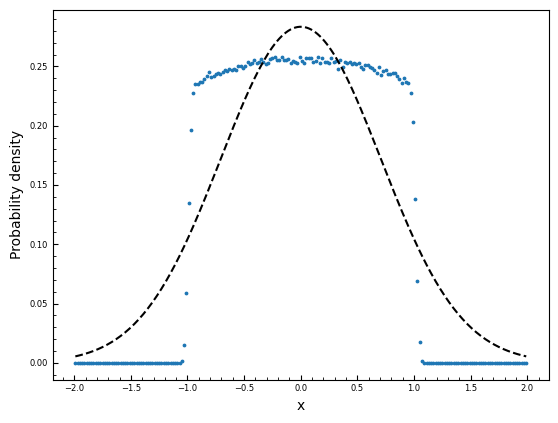

In [37]:
# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf_y * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic * dx):.5f}")
save_path = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\Summative_Wavefunction"

plt.figure(1)
plt.scatter(y_centres, pdf_y, label='Path integral estimate', s=3)
plt.plot(y_centres, phi_sq_analytic, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')

plt.minorticks_on()
plt.tick_params(axis = 'both',which = 'major', direction = 'in')
plt.tick_params(axis = 'both',which = 'minor', direction = 'in')
plt.tick_params(which = 'major', labelsize = 6)
plt.tick_params(which = 'minor', labelsize = 3)

plt.savefig(save_path, bbox_inches='tight', format='svg')
plt.show()

In [ ]:
vary = np.linspace(-2, 2, 400)
omega = np.sqrt(2)  # harmonic approximation near minima
# Gaussian around each well
psi_left = (omega/np.pi)**0.25 * np.exp(-0.5*omega*(vary+1)**2)
psi_right = (omega/np.pi)**0.25 * np.exp(-0.5*omega*(vary-1)**2)
# Symmetric ground state
psi0 = (psi_left + psi_right)/np.sqrt(2)
pdf_vary = np.abs(psi0)**2
pdf_vary /= np.trapezoid(pdf_vary, vary)  # normalize

plt.plot(vary, pdf_vary)

In [ ]:
#Now seeking to produce the 3-D plot for x and y

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.animation import PillowWriter
from matplotlib.animation import FuncAnimation

X,Y = np.meshgrid(x_centres, y_centres)

PDF = np.outer(pdf_y, pdf_x)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Documents\\Durham Work\\Year 3\\CompPhys\\wavefunction_3D.svg'

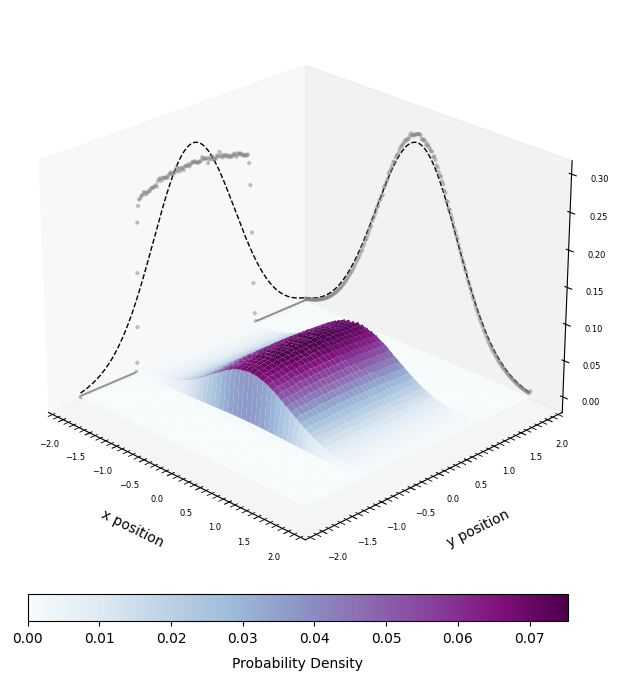

In [30]:
save_path_3d = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\wavefunction_3D.svg"

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(left=0)  # leave extra space

surf = ax.plot_surface(-X, Y, PDF, cmap='BuPu', antialiased=True, linewidth=0)


cbar = fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.02, orientation = 'horizontal')
cbar.ax.set_position([0.1, 0.2, 0.7, 0.03])  # ([L,B,W,H])
cbar.set_label("Probability Density", labelpad=8)


ax.set_xlabel("x position", labelpad=10)
ax.set_ylabel("y position", labelpad=10)

ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r"$|\psi(x,y)|^2$", labelpad=12, rotation=0)

ax.view_init(elev=25, azim = -45)

ax.grid(False)

ax.minorticks_on()
ax.tick_params(axis = 'both',which = 'major', direction = 'in')
ax.tick_params(axis = 'both',which = 'minor', direction = 'in')
ax.tick_params(which = 'major', labelsize = 6)
ax.tick_params(which = 'minor', labelsize = 3)

# --- X-PDF projection onto the back Y-wall ---
Y_wall = np.full_like(x_centres, np.max(y_centres))
ax.scatter(x_centres, Y_wall, pdf_x, color="grey", linewidth=2, label="x-PDF projection", s = 1, alpha = 0.5)
ax.plot(x_centres, Y_wall, phi_sq_analytic, color="black", linewidth=1, label="x-PDF projection", linestyle = "--")

# --- Y-PDF projection onto the left X-wall ---
X_wall = np.full_like(y_centres, np.min(x_centres))
ax.scatter(X_wall, y_centres, pdf_y, color="grey", linewidth=2, label="y-PDF projection", s = 1, alpha = 0.5)
ax.plot(X_wall, y_centres, phi_sq_analytic, color="black", linewidth=1, label="y-PDF projection", linestyle = "--")

plt.savefig(save_path_3d,bbox_inches = 'tight', format='svg')
plt.show()

In [31]:
def animate(i):
    # total frames = N
    N = 120

    # Map i → a value that goes 0→1→0 smoothly
    phase = 2 * abs((i / (N/2)) % 2 - 1)   # triangle wave between 0 and 1

    # Now map the phase into angles 30 → 150 → 30
    azim = 30 + phase * (150 - 30)

    ax.view_init(elev=25, azim=azim)


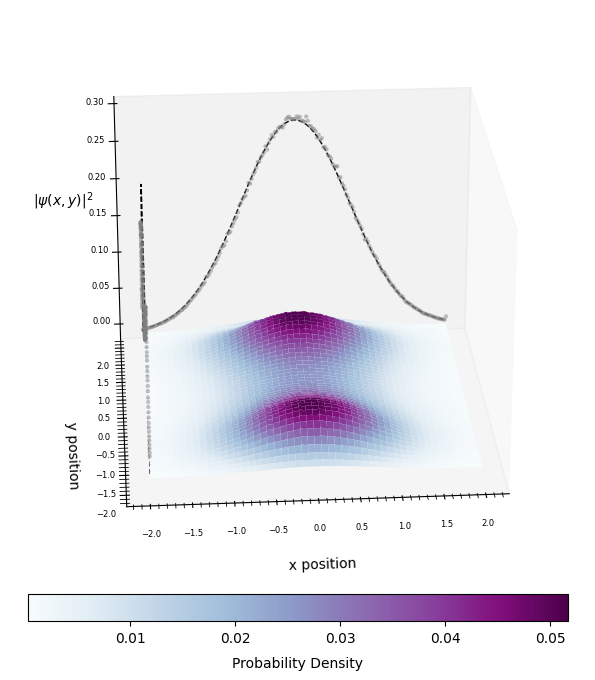

In [333]:
save_path_3d_rot = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\wavefunction_3D_rot.gif"

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(left=0)  # leave extra space

surf = ax.plot_surface(-X, Y, PDF, cmap='BuPu', antialiased=True, linewidth=0)


cbar = fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.02, orientation = 'horizontal')
cbar.ax.set_position([0.1, 0.2, 0.7, 0.03])  # ([L,B,W,H])
cbar.set_label("Probability Density", labelpad=8)


ax.set_xlabel("x position", labelpad=10)
ax.set_ylabel("y position", labelpad=10)

ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r"$|\psi(x,y)|^2$", labelpad=12, rotation=0)

ax.view_init(elev=25, azim = -45)

ax.grid(False)

ax.minorticks_on()
ax.tick_params(axis = 'both',which = 'major', direction = 'in')
ax.tick_params(axis = 'both',which = 'minor', direction = 'in')
ax.tick_params(which = 'major', labelsize = 6)
ax.tick_params(which = 'minor', labelsize = 3)

# --- X-PDF projection onto the back Y-wall ---
Y_wall = np.full_like(x_centres, np.max(y_centres))
ax.scatter(x_centres, Y_wall, pdf_x, color="grey", linewidth=2, label="x-PDF projection", s = 1, alpha = 0.5)
ax.plot(x_centres, Y_wall, phi_sq_analytic, color="black", linewidth=1, label="x-PDF projection", linestyle = "--")

# --- Y-PDF projection onto the left X-wall ---
X_wall = np.full_like(y_centres, np.min(x_centres))
ax.scatter(X_wall, y_centres, pdf_y, color="grey", linewidth=2, label="y-PDF projection", s = 1, alpha = 0.5)
ax.plot(X_wall, y_centres, phi_sq_analytic, color="black", linewidth=1, label="y-PDF projection", linestyle = "--")


ani = animation.FuncAnimation(
    fig, animate,
    frames=720,      # number of frames (e.g., 2 full rotations)
    interval=50      # ms per frame
)

ani.save(save_path_3d_rot,writer = 'pillow', fps = 50, dpi = 100)
plt.show()